In [1]:
import numpy as np
import tensorflow as tf
import utils
from tictactoegame import TicTacToe as Board
import matplotlib.pyplot as plt
from IPython.display import clear_output

import os

2024-04-09 12:02:24.261698: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


define function to allow interactive play with agent

In [2]:
def play(policy):
    agent = RLNN(0.1,0.5)
    if isinstance(policy, str):
        agent.policy.load_weights('./checkpoints/' + policy)
    else:
        agent = policy
    
    while True:
        display = np.arange(1,10).reshape((3,3)).astype(str)
        board = Board()
        board.board
        bot = None
        player = input('x\'s or o\'s?')# == 'x'
        clear_output()
        if player == 'x':
            bot = 'o'
            print(board.board, display)
            move = int(input('your move:'))
            move = divmod(move-1,3)
            display[move[0],move[1]] = player
            board.setPiece(move, -1) # <-- multiply by -1 later on?
#             clear_output()
        else: # <-- bot is x's
            bot = 'x'
        while (board.isGameOver(1)==False and board.isGameOver(-1)==False
              and len(board.getPosns(0))!=0):
            clear_output()
            state = utils.board_to_features(board.board.copy()).T
            opp = utils.get_action(tf.squeeze(agent(state)).numpy())
            display[opp[0],opp[1]] = bot
            board.setPiece(opp,1)
            print(board.board)
            print(display)
            if (board.isGameOver(1) or board.isGameOver(-1) or len(board.getPosns(0))==0):
                break
            move = int(input('your move:'))
            move = divmod(move-1,3)
            display[move[0],move[1]] = player
            board.setPiece(move, -1) # <-- multiply by -1 later on?
#             clear_output()
        board.board = display
        if board.isGameOver(player): 
            print('YOU WON!')
        elif board.isGameOver(bot):
            print('YOU LOST')
        else:
            print('DRAW')
        if input("play again? (1 for yes, 0 for no)") == '1':
            clear_output()
            continue
        else:
            break

In [918]:
play('Xs_baseline')

[[ 0 -1  1]
 [ 0 -1  0]
 [ 1  0  1]]
[['1' 'o' 'x']
 ['4' 'o' '6']
 ['x' '8' 'x']]


your move: 8


YOU WON!


play again? (1 for yes, 0 for no) 0


define utility functions for preprocessing and reward

In [123]:
def preprocess_data(episode, padding=False, record='p1',conv=False):
    flip = 1
    if record=='p2': 
        flip = -1
    A, S = zip(*episode[:-1])
    A = list(reversed(A))
    r = reward_fn(episode[-1], record=record) # <-- call to global reward function
    for i in range(len(A)):
        A[i] = 3*A[i][0] + A[i][1] # <-- convert 2D coord to 1D index
    S = list(reversed(S))
    if conv==False:
        for i in range(len(S)):
            S[i] = utils.board_to_features(S[i]*flip).T
        S = np.concatenate(S, axis=0).astype(float)
    else:
        S = np.stack(S,axis=0)
        S = np.expand_dims(S,axis=-1).astype(float)
    if padding==True: # <-- idea was for if all action-state pairs were fed concurrently, but I think I ended up doing smth different
        fill_len = 8-len(A)
        A = tf.pad(np.array(A), np.array([[0,fill_len]]) ,"CONSTANT")
        S = tf.pad(S, np.array([[0,fill_len],[0,0]]), "CONSTANT")
    else:
        A = np.array(A)
    return A,S,r 

def reward_fn(state,record='p1'):
    flip = 1
    if record=='p2':
        flip=-1
    board = Board()
    board.board = state
    if board.isGameOver(1):
        return 1*flip
    if board.isGameOver(-1):
        return -1 *flip
    if 9 in board.board:
        return -1
    if len(board.getPosns(0))==0:
        return 0
    return 0

def moving_average(x,size,mult):
    x_prime=[]
    while mult > 0:
        x_smooth=[]
        for i in range(len(x)-size if len(x_prime)==0 else len(x_prime)-size):
            x_smooth.append(np.mean(x[i:i+size] if len(x_prime)==0 else x_prime[i:i+size]))
        x_prime=x_smooth
        mult-=1
    return x_prime

In [127]:
class RLNN():
    def __init__(self, alpha, gamma, conv=True):
        self.discount = tf.constant([gamma**t for t in range(8)],dtype=tf.float32)
        self.alpha = alpha
        self.gamma = gamma
        self.conv=conv

        self.V = tf.keras.Sequential()
        self.V.add(tf.keras.layers.Dense(64, activation='relu',kernel_regularizer='l2'))
        self.V.add(tf.keras.layers.Dense(64,activation='relu'))
        self.V.add(tf.keras.layers.Dense(1))
        
        self.policy = tf.keras.Sequential()
        if conv==False:
            self.dense1 = tf.keras.layers.Dense(18, activation='relu', kernel_regularizer='l2')
    #         self.dense2 = tf.keras.layers.Dense(18, kernel_regularizer='l2')
            self.dense3 = tf.keras.layers.Dense(9,activation='relu')
            self.logits = tf.keras.layers.Dense(9)
            self.softmax= tf.keras.layers.Activation(tf.nn.softmax)
            self.policy.add(self.dense1)
            self.policy.add(self.dense3)
            self.policy.add(self.logits)
            self.policy.add(self.softmax)
        else:
            self.C1 = tf.keras.layers.Conv2D(2, (3,3), activation='relu',kernel_regularizer='l2',padding='same')
            self.C2 = tf.keras.layers.Conv2D(1, (2,2), activation='relu',padding='same')
            self.D1 = tf.keras.layers.Dense(9)
            self.logits = tf.keras.layers.Dense(9)
            self.softmax= tf.keras.layers.Activation(tf.nn.softmax)
            self.flat = tf.keras.layers.Flatten()
            self.policy.add(self.C1)
            self.policy.add(self.C2)
            self.policy.add(self.flat)
            self.policy.add(self.D1)
            self.policy.add(self.logits)
            self.policy.add(self.softmax)
     
    @tf.function
    def __call__(self, st, valid_only=False):
        print('retracing!') # <-- test
        S = tf.cast(st,tf.float32)
        if self.conv==False:
            if valid_only==False:
                return self.policy(st)
            mask = tf.reduce_sum(tf.reshape(st, (2,9)),axis=0)
            probs = self.logits(self.dense3(self.dense1(st)))
            probs = tf.where(mask!=0, -np.inf, probs)
            return tf.nn.softmax(probs)
        if valid_only==False:
            return self.policy(tf.expand_dims(S,axis=-1))
        probs = self.logits(self.D1(self.flat(self.C2(self.C1(tf.expand_dims(S,axis=-1))))))
        probs = tf.where(tf.reshape(S,(1,9))!=0,-np.inf,probs)
        return tf.nn.softmax(probs)

# ------------------------------------------------------------------ #    
# Returns the gradient-log-probabilities multiplied by the reward-to-go, summed over each state-action pair.
    @tf.function(input_signature=((tf.TensorSpec(shape=[None]),
                                   tf.TensorSpec(shape=[None,3,3,1]),#tf.TensorSpec(shape=[None,18]),
                                 tf.TensorSpec(shape=None,dtype=tf.int32)),tf.TensorSpec(shape=[None])))

    def get_pg(self, episode, discount, baseline=False): #, reward_fn, record='p1'):
        print('retracing get_pg()!')
        (A,S,r) = episode
        A=tf.cast(A,dtype=tf.int32)
        r=tf.cast(r,dtype=tf.float32)
        A = tf.one_hot(A,depth=9)
        
        if baseline==True:
            v_hat = self.V(S)
    #         v_hat = 1-v_hat if r!=1 else v_hat
    #         V = discount*(r-v_hat)
            V = discount*r - v_hat
    #         V = discount*(r-v_hat*r)
        else:
            V = discount*r
        with tf.GradientTape(persistent=False) as tape:
            probs = self.policy(S)
#             logp = tf.math.log(probs[A!=0]+0.00000001)
            indices = tf.where(A)
            probs = tf.gather_nd(probs, indices=indices)
            logp = tf.math.log(probs+0.00000001)
            logp = tf.reduce_sum(logp * V)
        grads = tape.gradient(logp, self.policy.variables)
        return grads
    
# ------------------------------------------------------------------ #      

    def train(self,opp=None, epochs=100, batch_size=10, reward_fn=reward_fn, baseline=False,valid_only=False,record='p1'):
        flip = 1
        if record=='p2':
            flip = -1
        board=Board()
        illegals=[]
        losses=[]
        wins=[]
        draws=[]
        n = 1
        while n <= epochs:
            grad_count=0
            illegal=0
            win=0
            lose=0
            draw=0
            print(n)
            clear_output(wait=True)
            g_hat = []
            STATE_DATA=[]
            STATE_VALUES=[]
            if (record=='p1'):
                batch = [utils.gen_episode(self,p2=opp,record=record,valid_only=valid_only,conv=self.conv) for i in range(batch_size)]
            else:
                batch = [utils.gen_episode(p1=opp,p2=self,record=record,valid_only=valid_only,conv=self.conv) for i in range(batch_size)]
            for episode in batch:
                grad_count+= len(episode)-1
                data = preprocess_data(episode,record=record,conv=self.conv)
                discount = tf.constant(self.discount[:len(episode)-1])
                if baseline==True:
                    STATE_DATA.append(data[1])
    #                 STATE_VALUES.append(np.ones(len(episode)-1) if data[2]==1 else np.zeros(len(episode)-1))
                    STATE_VALUES.append(np.full((len(episode)-1,), data[2]) * discount)
                
                
                grads = self.get_pg(episode=data,discount=discount,baseline=baseline)
                if len(g_hat) == 0:
                    g_hat = grads
                else:
                    for i in range(len(grads)):   # <-- for computing expected policy gradient
                        g_hat[i] += grads[i]
                board.board = episode[-1]
                if 9 in episode[-1]: # <--- gotta fix these so stats recorded properly for p2
                    illegal+=1
                elif board.isGameOver(-1):
                    lose+=1
                elif board.isGameOver(1):
                    
                    win+=1
                else:
                    draw+=1
                    
            if baseline==True:
                STATE_DATA=np.concatenate(STATE_DATA,axis=0)
                STATE_VALUES=np.concatenate(STATE_VALUES)
                loss,steps=self.train_V(STATE_DATA,STATE_VALUES)
                print('loss = ', loss)
                print('epochs = ', steps)
            
            g_hat = [i / grad_count for i in g_hat] # <-- since gradient is calculated on each time step of an episode
            for grad, var in zip(g_hat, self.policy.variables):
                var.assign_add(self.alpha*grad)
            n+=1
            illegals.append(illegal/batch_size)
            losses.append(lose/batch_size)
            wins.append(win/batch_size)
            draws.append(draw/batch_size)
        return illegals,losses,wins,draws

    def train_V(self, S,R,lr=0.01,optimality=0.2,max_epochs=50):
        epoch = 0
        R=tf.cast(R,tf.float32)
        while epoch < max_epochs:
            loss = self.tr_step_V(S,R,lr=lr)
#             print(loss)
#             clear_output()
            if loss <= optimality:
                return loss,epoch
            epoch+=1
        return loss,epoch
        
    @tf.function
    def tr_step_V(self,S,R,lr=0.1):
        with tf.GradientTape() as tape:
            loss = tf.math.reduce_mean((self.V(S) - R)**2)
#             loss = R*tf.math.log(self.V(S)) + (1-R)*tf.math.log(1-self.V(S)) # <-- logistic or L2 regression is best?
#             loss = -1*tf.math.reduce_mean(loss) #<-- reduce sum or mean?
        grads = tape.gradient(loss, self.V.variables)
        for grad,var in zip(grads,self.V.variables):
            var.assign_sub(lr*grad)
            return loss



In [131]:
X1 = RLNN(1e-1, 0.5)

In [91]:
X2 = RLNN(1e-1, 0.5,conv=False)

In [132]:
IR,LR,WR,DR = X1.train(epochs=50,batch_size=10,valid_only=True, baseline=False)
# IR,LR,WR,DR = X2.train(epochs=50,batch_size=10,valid_only=False, baseline=False)
I+=IR
L +=LR
W += WR
D += DR

illegal+=IR
lose +=LR
win += WR
draw += DR

50


In [44]:
I = []
L = []
W = []
D = []

illegal = []
lose = []
win = []
draw = []

illeg_2 = []
lose_2 = []
win_2 = []
draw_2 = []

In [812]:
for i in range(30):
#     print(i)
#     clear_output()
    IR,LR,WR,DR = Xs.train2(epochs=10, batch_size=10, reward_fn=reward_fn,opp=Os,testing=True, record='p1')

    I+=IR
    L +=LR
    W += WR
    D += DR
    illegal+=IR
    lose +=LR
    win += WR
    draw += DR

    IR,LR,WR,DR = Os.train2(epochs=10, batch_size=10, reward_fn=reward_fn,opp=Xs,testing=True, record='p2')

    I+=IR
    L +=LR
    W += WR
    D += DR
    illeg_2+=IR
    lose_2 +=LR
    win_2 += WR
    draw_2 += DR


loss =  tf.Tensor(0.016744347, shape=(), dtype=float32)
epochs =  0


In [204]:
IR,LR,WR,DR = Os.train2(epochs=2000, batch_size=10, reward_fn=reward_fn,opp=Xs,baseline=False,conv=True, record='p2')
# IR,LR,WR,DR = Xs.train2(epochs=50, batch_size=10, reward_fn=reward_fn,opp=Os,testing=True, record='p1')
I+=IR
L +=LR
W += WR
D += DR
illeg_2+=IR
lose_2 +=LR
win_2 += WR
draw_2 += DR

2000


[Text(0.5, 0, 'epoch'), Text(0.5, 1.0, 'outcome frequencies (all)')]

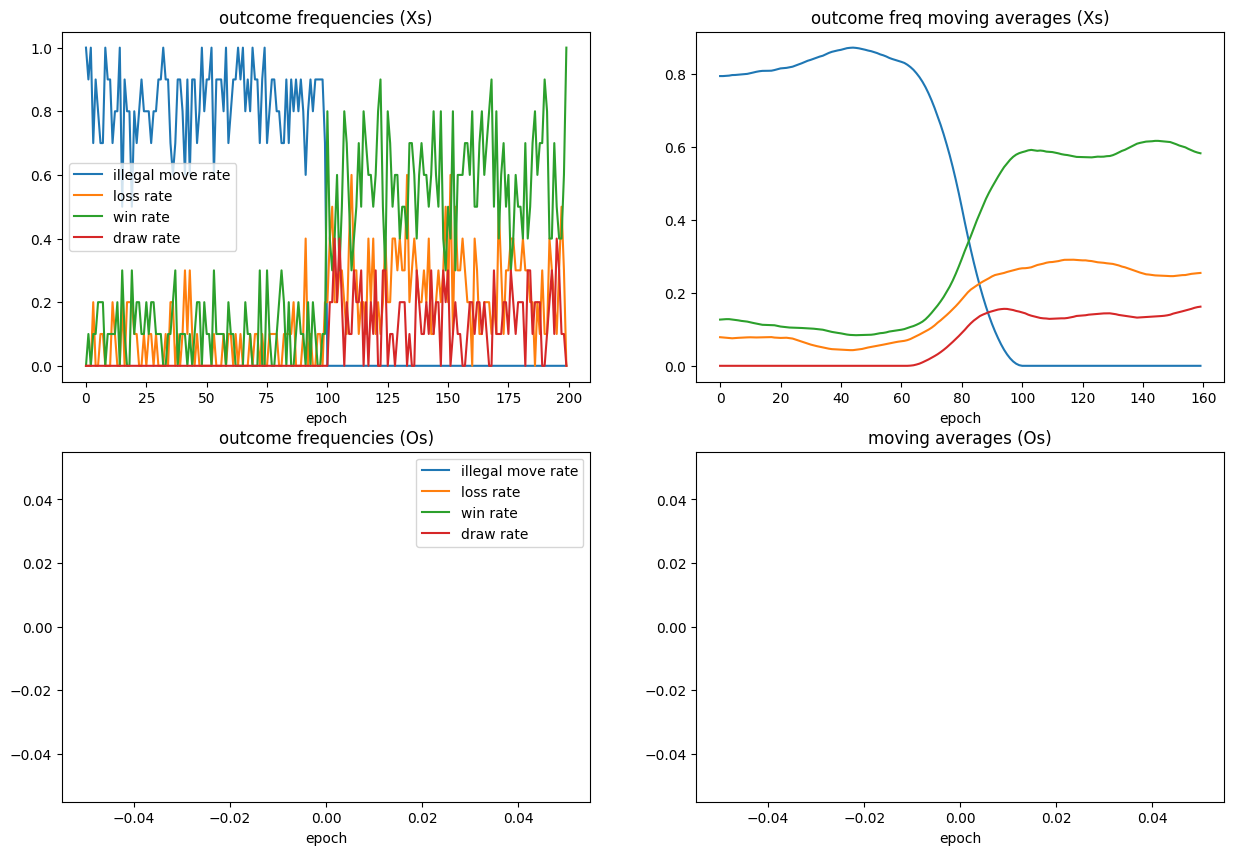

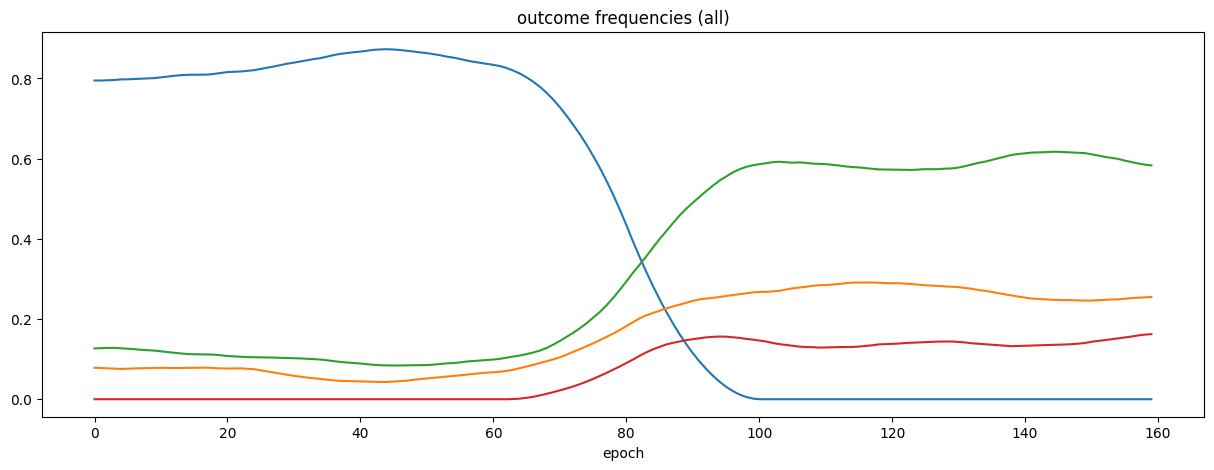

In [133]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(illegal, label='illegal move rate')
ax[0,0].plot(lose, label='loss rate')
ax[0,0].plot(win, label='win rate')
ax[0,0].plot(draw,label='draw rate')
ax[0,0].set(xlabel='epoch', title='outcome frequencies (Xs)')
ax[0,0].legend()

ax[0,1].plot(moving_average(illegal, 20,2))
ax[0,1].plot(moving_average(lose, 20,2))
ax[0,1].plot(moving_average(win, 20,2))
ax[0,1].plot(moving_average(draw, 20,2))
ax[0,1].set(xlabel='epoch', title='outcome freq moving averages (Xs)')

ax[1,0].plot(illeg_2, label='illegal move rate')
ax[1,0].plot(lose_2, label='loss rate')
ax[1,0].plot(win_2, label='win rate')
ax[1,0].plot(draw_2,label='draw rate')
ax[1,0].set(xlabel='epoch', title='outcome frequencies (Os)')
ax[1,0].legend()

ax[1,1].plot(moving_average(illeg_2, 20,2))
ax[1,1].plot(moving_average(lose_2, 20,2))
ax[1,1].plot(moving_average(win_2, 20,2))
ax[1,1].plot(moving_average(draw_2, 20,2))
ax[1,1].set(xlabel='epoch', title='moving averages (Os)')

fig2, ax2 = plt.subplots(figsize=(15,5))
ax2.plot(moving_average(I,20,2), label='illegal move rate')
ax2.plot(moving_average(L,20,2), label='loss rate')
ax2.plot(moving_average(W,20,2), label='win rate')
ax2.plot(moving_average(D,20,2),label='draw rate')
ax2.set(xlabel='epoch', title='outcome frequencies (all)')


# ^^^add code to record and plot returns as well

In [ ]:
utils.state_dist(p1,200)

In [124]:
test = RLNN(1e-1,0.5)

In [294]:
utils.gen_episode(p1=Xs,p2=None, record='p1',conv=True)

[((1, 1),
  array([[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]])),
 ((1, 0),
  array([[-1,  0,  0],
         [ 0,  1,  0],
         [ 0,  0,  0]])),
 ((1, 2),
  array([[-1, -1,  0],
         [ 1,  1,  0],
         [ 0,  0,  0]])),
 array([[-1, -1,  0],
        [ 1,  1,  1],
        [ 0,  0,  0]])]